### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText
import pandas as pd
from engine.ner_detector import text_preprocess

c:\Users\1234o\Studies\Sem2\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [3]:
test = pd.read_csv("data/coaid/test.csv")
test['text'] = text_preprocess(test['text'].to_list())
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0                  Eddie Van Halen Dies of Cancer at 65      0
1     Have the Public Health Restrictions Gone Too F...      0
2     My experience battling COVID-19 - Medical News...      0
3     U.S. Government to Increase PPE Shipments to N...      0
4     Frequently Asked Questions about Hand Hygiene ...      0
...                                                 ...    ...
1087  How to Enjoy the Fourth of July Weekend Amid t...      0
1088         Wearing a Mask Doesn't Cause CO2 Poisoning      0
1089  Brain Affected in 1 in 3 Cases of Severe COVID-19      0
1090      CDC Reverses Guidance on Asymptomatic Testing      0
1091  Guidance for Child Care Programs that Remain Open      0

[1092 rows x 2 columns]


Map: 100%|██████████| 1092/1092 [00:00<00:00, 2599.15 examples/s]


In [4]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [5]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [6]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [7]:
obs = test["text"].tolist()[247]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries
tensor([[    0, 47948, 31466,    13, 39046,     9,  6247, 43814,    12,  1646,
          2573, 12663, 18541, 34131,    13,  9978,    12, 47279, 17658,     2]])


In [8]:
test["text"].tolist()[247]

'Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries'

In [9]:
def forward(obs):
    return model(obs).logits

In [10]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000e+00, -1.6391e-06,  1.2070e-06,  2.8312e-07,  4.1872e-06,
           2.0862e-06, -1.2517e-06,  7.5996e-07, -5.2154e-07, -3.8743e-07,
          -1.9073e-06, -1.4752e-06,  1.3709e-06,  3.1739e-06,  9.2387e-07,
          -1.8328e-06,  1.0431e-07,  3.6210e-06, -2.1309e-06,  3.5763e-07],
         [ 0.0000e+00, -7.4133e-07, -1.3039e-07, -5.7742e-07,  1.1157e-06,
           2.9616e-07, -1.6503e-06, -2.4214e-07, -7.4878e-07, -7.5810e-07,
          -1.4566e-06, -1.2051e-06, -1.3039e-07,  3.7253e-07, -7.3574e-07,
          -1.2554e-06, -1.2033e-06, -6.0722e-07, -1.5758e-06, -1.0878e-06]]])

In [11]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Fram', 'ework', 'Ġfor', 'ĠImplementation', 'Ġof', 'ĠCO', 'VID', '-', '19', 'ĠCommunity', 'ĠMit', 'igation', 'ĠMeasures', 'Ġfor', 'ĠLower', '-', 'Resource', 'ĠCountries', '</s>']


In [12]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Lower-Resource Countries (ORG) - Companies, agencies, institutions, etc.


In [13]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Framework, Not part of any entity.
Token: for, Not part of any entity.
Token: Implementation, Not part of any entity.
Token: of, Not part of any entity.
Token: COVID-19, Not part of any entity.
Token: Community, Not part of any entity.
Token: Mitigation, Not part of any entity.
Token: Measures, Not part of any entity.
Token: for, Not part of any entity.
Token: Lower, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: -, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Resource, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Countries, Entity Type: ORG (Companies, agencies, institutions, etc.)


In [14]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

20
['Fram', 'ework', 'for', 'Implementation', 'of', 'CO', 'VID', '-', '19', 'Community', 'Mit', 'igation', 'Measures', 'for', 'Lower', '-', 'Resource', 'Countries']
tensor([[[ 0.0000e+00, -1.6391e-06,  1.2070e-06,  2.8312e-07,  4.1872e-06,
           2.0862e-06, -1.2517e-06,  7.5996e-07, -5.2154e-07, -3.8743e-07,
          -1.9073e-06, -1.4752e-06,  1.3709e-06,  3.1739e-06,  9.2387e-07,
          -1.8328e-06,  1.0431e-07,  3.6210e-06, -2.1309e-06,  3.5763e-07],
         [ 0.0000e+00, -7.4133e-07, -1.3039e-07, -5.7742e-07,  1.1157e-06,
           2.9616e-07, -1.6503e-06, -2.4214e-07, -7.4878e-07, -7.5810e-07,
          -1.4566e-06, -1.2051e-06, -1.3039e-07,  3.7253e-07, -7.3574e-07,
          -1.2554e-06, -1.2033e-06, -6.0722e-07, -1.5758e-06, -1.0878e-06]]])
1


In [15]:
from engine.tokens_aggregate import TokenAggregate

In [16]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp[0],tokens_clear,tokens)

In [17]:
from engine.xai import FeatureAblation
from engine.tokens_aggregate import TokenAggregate
from engine.ner_detector import tokenize_evaluate_and_detect_NERs,generate_aggregates

all_aggregate = generate_aggregates(pipeline,[test["text"].tolist()[16]])

1it [00:00,  1.50it/s]


In [18]:
print(all_aggregate)

[[<engine.tokens_aggregate.TokenAggregate object at 0x000001E400DAA090>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFACF0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFAAE0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFAD50>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFAB10>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFB470>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFAC30>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFB6E0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFA9C0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001E401DFA720>]]


In [19]:
for doc_aggreagtes in all_aggregate:
    for aggregate in doc_aggreagtes:
        # if(len(aggregate.spacy_token)>1):
        print(aggregate)

Is spacy NER: ['']
spacy token: ['Why']
Our model clean: ['Why']
Our model dirty: ['Why']
model exp: [-8.493661880493164e-07]

Is spacy NER: ['']
spacy token: ['are']
Our model clean: ['are']
Our model dirty: ['Ġare']
model exp: [-3.7103891372680664e-06]

Is spacy NER: ['']
spacy token: ['infections']
Our model clean: ['infections']
Our model dirty: ['Ġinfections']
model exp: [-1.6391277313232422e-07]

Is spacy NER: ['']
spacy token: ['from']
Our model clean: ['from']
Our model dirty: ['Ġfrom']
model exp: [-1.1026859283447266e-06]

Is spacy NER: ['']
spacy token: ['animals']
Our model clean: ['animals']
Our model dirty: ['Ġanimals']
model exp: [-1.5050172805786133e-06]

Is spacy NER: ['']
spacy token: ['so']
Our model clean: ['so']
Our model dirty: ['Ġso']
model exp: [1.043081283569336e-06]

Is spacy NER: ['']
spacy token: ['dangerous']
Our model clean: ['dangerous']
Our model dirty: ['Ġdangerous']
model exp: [-1.6689300537109375e-06]

Is spacy NER: ['']
spacy token: ['to']
Our model c

In [20]:
test = pd.read_csv("data/isot/test.csv")

In [21]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist()[253:254],ners_to_calculate_ablation=['PERSON'])

1it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]
1it [00:00,  9.53it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]


1092it [00:00, 432214.77it/s]
100%|██████████| 1092/1092 [00:00<00:00, 54473.42it/s]
1092it [01:52,  9.70it/s]
100%|██████████| 1092/1092 [00:00<00:00, 74950.99it/s]


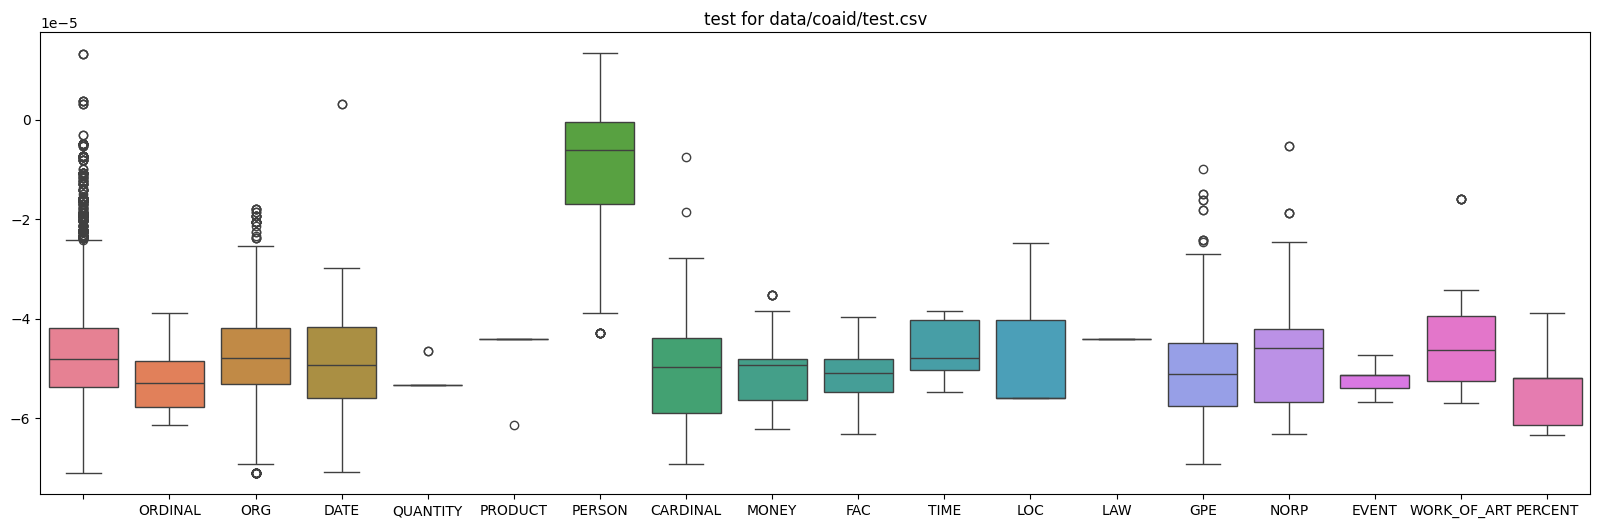

8980it [00:00, 28027.38it/s]
100%|██████████| 8980/8980 [00:00<00:00, 43379.29it/s]
8980it [16:34,  9.03it/s]
100%|██████████| 8980/8980 [00:00<00:00, 71878.25it/s]


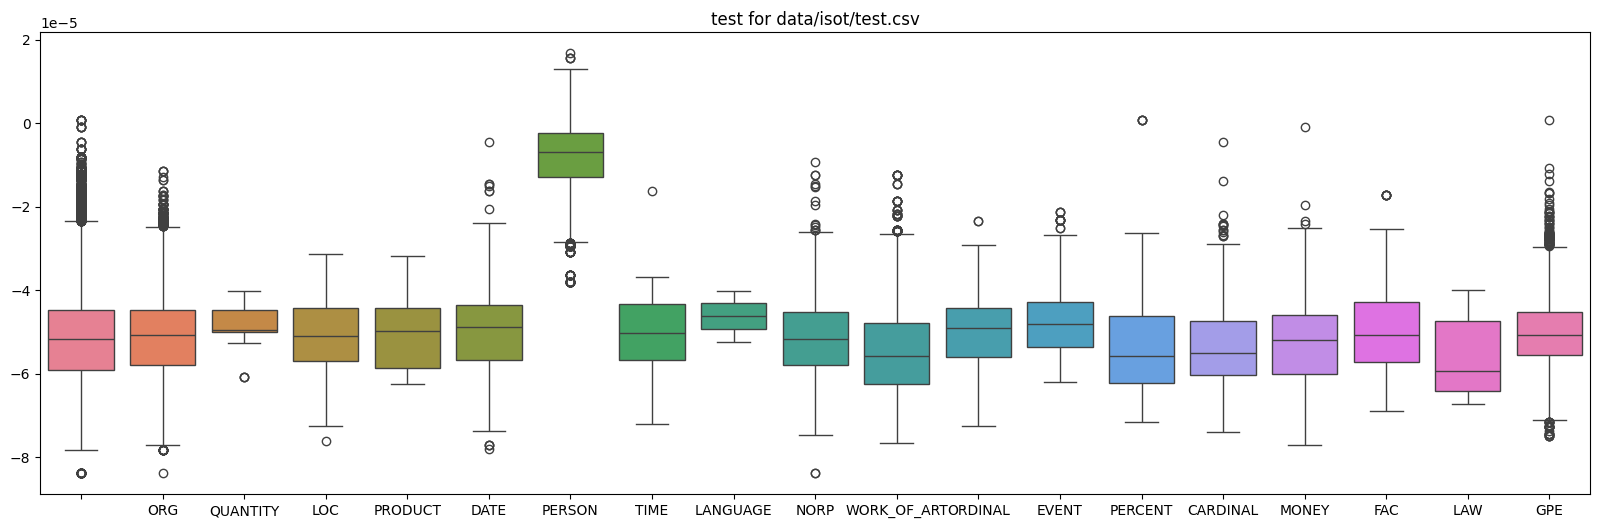

795it [00:00, ?it/s]
100%|██████████| 795/795 [00:00<00:00, 44018.27it/s]
795it [01:18, 10.07it/s]
100%|██████████| 795/795 [00:00<00:00, 57246.11it/s]


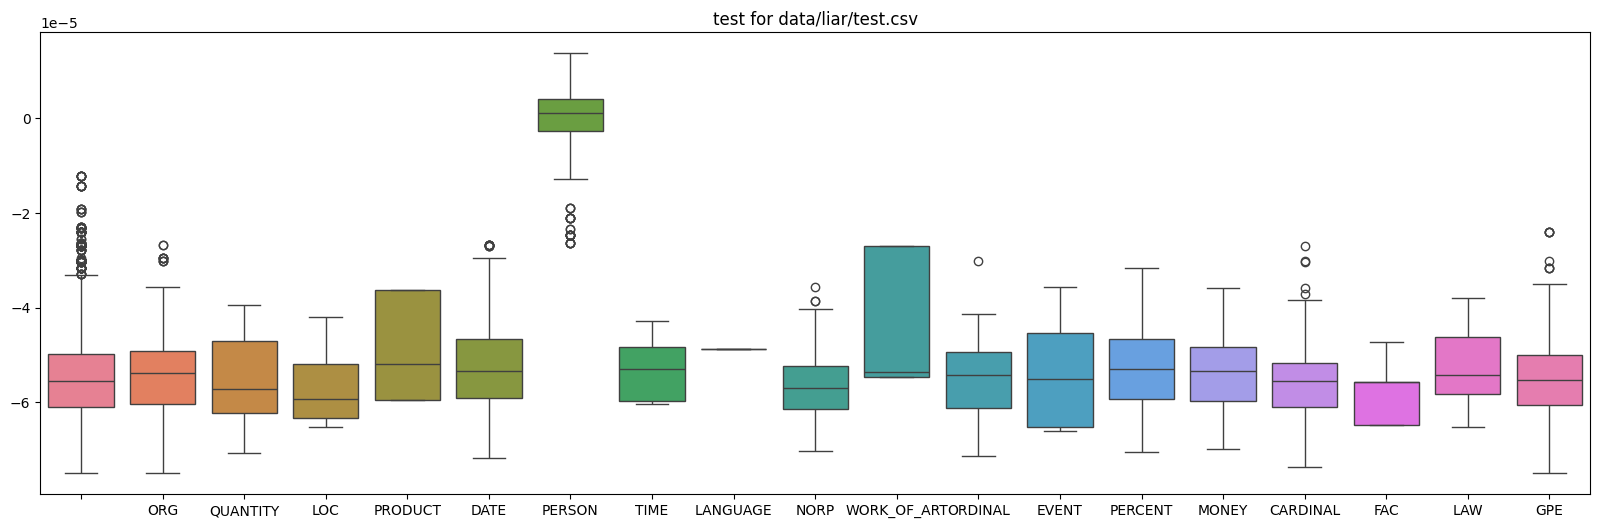

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["coaid","isot","liar"]
results_for_data_filtered = {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),ners_to_calculate_ablation=['PERSON'])
    results_for_data_filtered[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"test for {file}")
    plt.show()

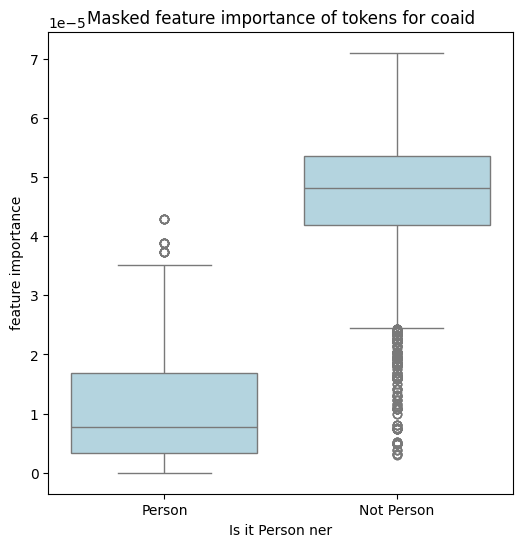

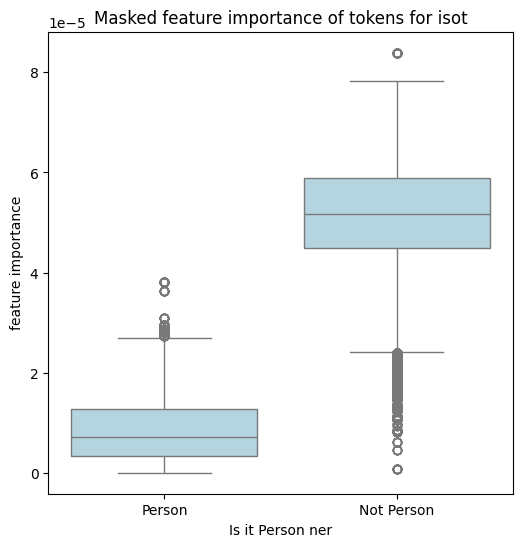

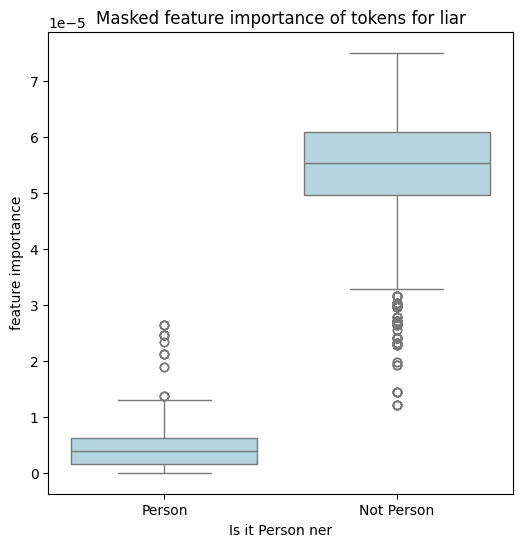

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_filtered[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {"Person":[],"Not Person":[]}


    for token, exp, ner in token_exp_NERs:
        if(ner == "PERSON"):
            exps["Person"].append(abs(exp))
        else:
            exps["Not Person"].append(abs(exp))

    plt.figure(figsize=(6, 6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Is it Person ner")
    sns.boxplot(data=exps, palette=box_colors)  # Pass the color list
    plt.title(f"Masked feature importance of tokens for {data_name}")
    plt.savefig(f"output\\feature_importance_graphs\\Masked feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["coaid","isot","liar"]
results_for_data_all_ners= {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist())
    results_for_data_all_ners[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"all ners test for {file}")
    plt.show()

390it [05:20,  1.22it/s]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_filtered[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)

    plt.figure(figsize=(20,6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Ner type")
    sns.boxplot(data=exps, palette=box_colors)  # Pass the color list
    plt.title(f"All ner feature importance of tokens for {data_name}")
    plt.savefig(f"output\\feature_importance_graphs\\All ner feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()
